In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [17]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), unzip = True):
    if unzip:
        unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = train_set_size + 1, sample_end = train_set_size + test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = train_set_size + test_set_size + 1, sample_end = train_set_size + test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel):
    png_path = "dataset8x16/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], channels), dtype="uint8")
    for ch in range(channels):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors", label_type = "categorical", category_group = None):
    labeled_data = []
    categories = []
    
    if category_group != None:
        categories = category_group
    else:
        categories = os.listdir(srs_path)
        categories.sort()

    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Regression MSE')
    pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
    pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, ave_error, max_error

def evaluate_regression(model, val_X, val_Y, accuracy_threshold):
    model_output = model.predict(val_X)
    error_tensor = val_Y - model_output
    error_x_tensor = error_tensor[:,0]
    error_y_tensor = error_tensor[:,1]
    loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
    mse, ave_error, max_error = compute_error (loss_distance)
    accuracy = np.count_nonzero(loss_distance < accuracy_threshold) / len(loss_distance)
    return mse, ave_error, max_error, accuracy

def evaluate_regression_TF_Lite(interpreter, val_X, val_Y, accuracy_threshold):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    val_Y_lite = np.zeros((len(val_Y), 2))
    for i in range(len(val_X)):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(val_X[i], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        val_Y_lite[i] = output_data

    error_tensor_lite = val_Y - val_Y_lite

    error_x_tensor_lite = error_tensor_lite[:,0]
    error_y_tensor_lite = error_tensor_lite[:,1]

    loss_distance_lite = np.sqrt(error_x_tensor_lite**2 + error_y_tensor_lite**2)

    accuracy_lite = np.count_nonzero(loss_distance_lite < accuracy_threshold) / len(loss_distance_lite)
    mse_lite, ave_error_lite, max_error_lite = compute_error(loss_distance_lite)
    return mse_lite, ave_error_lite, max_error_lite, accuracy_lite

def train_model(model, model_file_name = "model.h5", target_mse = 0.000001, accuracy_threshold = 0.10):
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    current_mse = 1
    while (target_mse < current_mse):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=1000, validation_data=(val_X, val_Y), verbose=1, callbacks=[monitor])
        validation_mse_, ave_error_, max_error_, validation_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
        if (validation_mse_ < current_mse):
            print("Validation MSE > {}".format(validation_mse_))
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_mse = validation_mse_
        else:
            if os.path.exists(model_file_name):
                model = load_model(model_file_name)

    print("{} has been trained, MSE = {}.".format(model_file_name, current_mse))

def convert_to_TF_Lite_float32 (model_file_name):
  model = load_model(model_file_name)

  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

  os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

  print("{} has been converted to TF Lite (float32).".format(model_file_name))

def convert_to_TF_Lite_int8 (model_file_name, val_X):
  ds_cast = tf.cast(val_X, tf.float32)
  ds_batch = tf.data.Dataset.from_tensor_slices((ds_cast)).batch(1)
  def representative_dataset():
    for input_value in ds_batch.take(100):
      # Model has only one input so each data point has one element.
      yield [input_value]

  model = load_model(model_file_name)
  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + "_i8" + '.tflite', 'wb') as f:
    f.write(tflite_model)

  print("{} has been converted to TF Lite (int8).".format(model_file_name))

def create_custom_training_set (srs_path, tokens):
    categories = os.listdir(srs_path)
    training_categories = []
    validation_categories = []
    for category in categories:
        is_train_category = False
        for token in tokens:
            if token in category:
                training_categories.append(category)
                is_train_category = True
        if not is_train_category:
            validation_categories.append(category)

    return list (dict.fromkeys(training_categories)), list (dict.fromkeys(validation_categories))


In [26]:
import struct

def bin2float(b):
    ''' Convert binary string to a float.

    Attributes:
        :b: Binary string to transform.
    '''
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    ''' Convert float to 64-bit binary string.

    Attributes:
        :f: Float number to transform.
    '''
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def quantize_float (float_number, exponent_bits, mantissa_bits):
    exponent_sign = 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    if mantissa_bits < 0:
      mantissa_bits = 0
    if exponent_bits < 0:
      exponent_bits = 0
      
    coefficient = float2bin(float_number)
    sign = int (coefficient[:1], 2)
    if 0 < mantissa_bits:
        custom_mantissa = int (coefficient[12 : 12 + mantissa_bits], 2)
    else:
        custom_mantissa = 0
    residual_mantissa = int (coefficient[12 + mantissa_bits:], 2)
    exponent = int (coefficient[1:12], 2) - 1023

    exponent_full_range = pow(2, exponent_bits - exponent_sign) - 1
    if exponent < - exponent_full_range:
        quantized_value = 0
    elif exponent > exponent_full_range:
        quantized_value = pow(-1, sign) * (1 + (1 - pow(2, - mantissa_bits))) * pow(2, exponent_full_range)
    else:
        if (pow (2, (52 - (mantissa_bits + 1))) - 1) < residual_mantissa:
            custom_mantissa += 1
            if (pow (2, mantissa_bits) - 1) < custom_mantissa:
                custom_mantissa = 0
                exponent += 1
    
        quantized_value = pow(-1, sign) * (1 + custom_mantissa * pow(2, - mantissa_bits)) * pow(2, exponent)
    return quantized_value

def quantize_model(model, exponent_bits, mantissa_bits):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      for index in range(len(layer_weights)):
        matrix = layer_weights[index]
        for weight_index, weight in np.ndenumerate(matrix):
          matrix[weight_index] = quantize_float(weight, exponent_bits, mantissa_bits)
        layer_weights[index] = matrix
      layer.set_weights(layer_weights)

class QuantizeCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_file_name, exponent_bits, mantissa_bits, current_mse, threshold_accuracy, refine_on_batch, quantize_enable):
    self.model_file_name = model_file_name
    self.threshold_accuracy = threshold_accuracy
    self.current_mse = current_mse
    self.refine_on_batch = refine_on_batch
    self.exponent_bits = exponent_bits
    self.mantissa_bits = mantissa_bits
    self.quantize_enable = quantize_enable

  def on_epoch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    test_mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)
    if (test_mse_ < self.current_mse):
      self.model.save(self.model_file_name)
      self.current_mse = test_mse_
      print(" Saveing model ...")

    print(" Regression MSE = {}".format(test_mse_))
  def on_train_end(self, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
  def on_batch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)

    if self.refine_on_batch:
      test_mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)
      if (test_mse_ < self.current_mse):
        self.model.save(self.model_file_name)
        self.current_mse = test_mse_
        print(" Saveing model ...")
        print(" Regression MSE {}".format(test_mse_))

def print_model(model):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      print (layer_weights)

In [4]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanSquaredError'])
    return model

In [5]:
def CNN_categorical(input_shape = (32, 32, 4), output_categories = 16):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_categories, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
google_service = True

absolute_path = ""

if google_service:
    from google.colab import drive
    google_drive_path = "/content/drive/MyDrive/PhD/Minized/"
    drive.mount('/content/drive/')
    absolute_path = google_drive_path

channel_sensors = 6

model_file_name = absolute_path + "model_8x16x" + str(channel_sensors) + ".h5" # Set the file name for the model
target_mse = 0.000005
accuracy_threshold = 0.15 # Radio-distance (in meters) to consider a correct regression

model_type = "regression" # set "regression" or "categorical"

zip_data_path = absolute_path + "dataset8x16.zip"
unzip_dataset = True

train_set_path = absolute_path + "train_set"
train_set_size = 1700

test_set_path = absolute_path + "test_set"
test_set_size = 400

validation_set_path = absolute_path + "validation_set"
validation_set_size = 400

crop_area = (0, 0, 16, 8) # x1, y1, x2, y2
size = (16, 8)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = channel_sensors,\
                    crop_area = crop_area,\
                    size = size,
                    unzip = unzip_dataset)

In [8]:
#tokens = ["x1_", "x10_", "_y1", "_y10", "x5_", "_y5"]
tokens = ["x5_", "_y5", "x2_y2", "x2_y9", "x9_y2", "x9_y9"]

training_group, validation_group = create_custom_training_set (srs_path = train_set_path, tokens = tokens)

In [9]:
train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type, category_group = training_group)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type, category_group = validation_group)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type, category_group = validation_group)

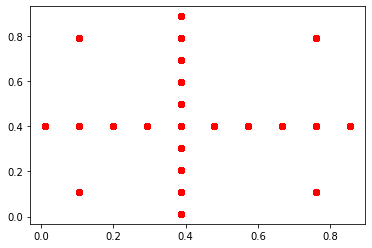

In [10]:
plt.scatter(train_Y[:,0], train_Y[:,1], c='r')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 16, 40)         2200      
                                                                 
 batch_normalization (BatchN  (None, 8, 16, 40)        160       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 8, 40)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 8, 40)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 8, 60)          21660     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 8, 60)         2

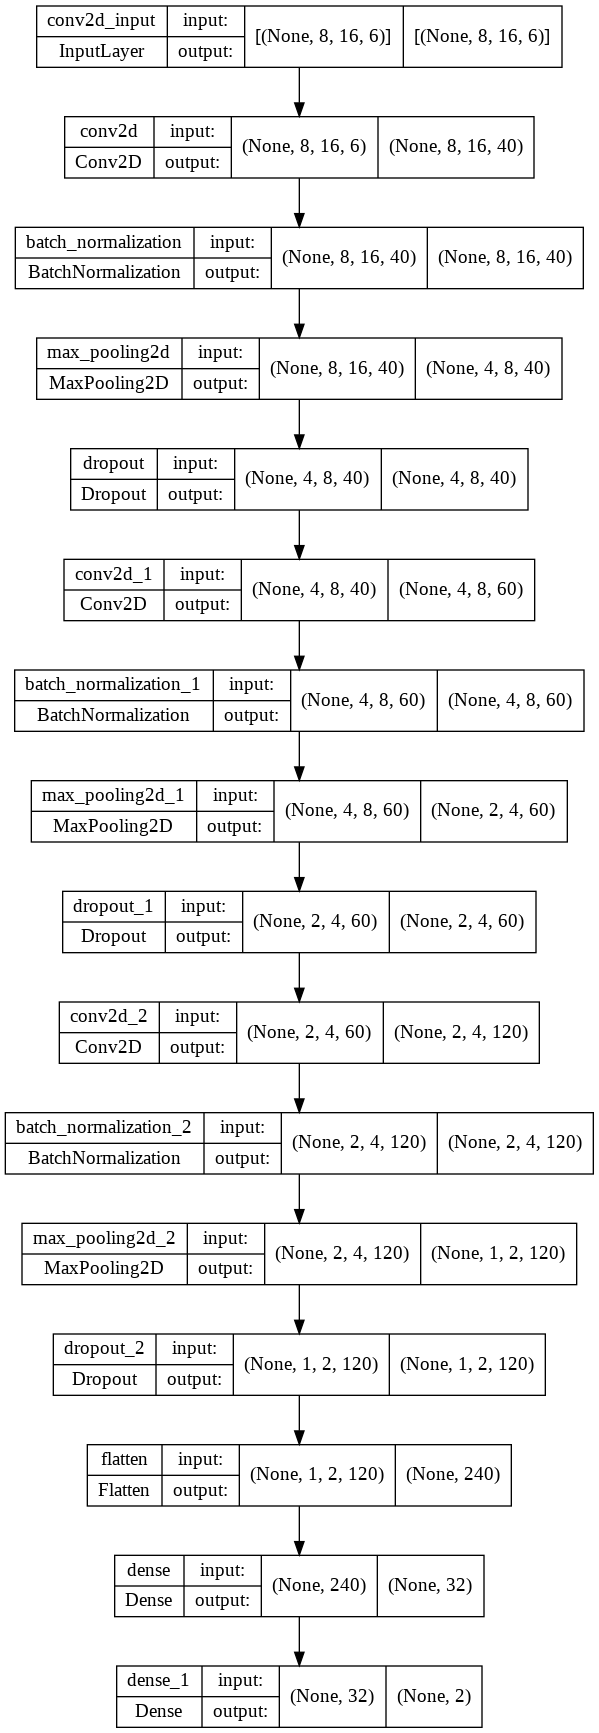

In [11]:
if model_type == "regression":
    model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
else:
    model = CNN_categorical(input_shape = (size[1], size[0], channel_sensors), output_categories = 16)

model.summary()

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
train_model(model = model, model_file_name = model_file_name, target_mse = target_mse, accuracy_threshold = accuracy_threshold)

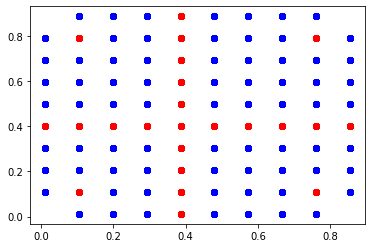

In [19]:
plt.scatter(train_Y[:,0], train_Y[:,1], c='r')
plt.scatter(val_Y[:,0], val_Y[:,1], c='b')
plt.show()

In [20]:
model = load_model(model_file_name)

mse, ave_error, max_error, accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse))
print("Ave error = {}".format(ave_error))
print("Max error = {}".format(max_error))
print("Accuracy = {}".format(accuracy))

Sensors = 6
MSE = 0.013576970275664577
Ave error = 0.1013485519242914
Max error = 0.7135058130100234
Accuracy = 0.856986301369863


In [21]:
convert_to_TF_Lite_float32(model_file_name)

INFO:tensorflow:Assets written to: /tmp/tmpkbl76bt7/assets


/content/drive/MyDrive/PhD/Minized/model_8x16x6.h5 has been converted to TF Lite (float32).


In [22]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpaiiz0olm/assets


INFO:tensorflow:Assets written to: /tmp/tmpaiiz0olm/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


/content/drive/MyDrive/PhD/Minized/model_8x16x6.h5 has been converted to TF Lite (int8).


In [23]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

mse_lite, ave_error_lite, max_error_lite, accuracy_lite = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)


print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse_lite))
print("Ave error = {}".format(ave_error_lite))
print("Max error = {}".format(max_error_lite))
print("Accuracy = {}".format(accuracy_lite))

Sensors = 6
MSE = 0.013535684664657804
Ave error = 0.1012752735081901
Max error = 0.705357896080068
Accuracy = 0.8573287671232876


In [ ]:
mantissa_bits = 1
exponent_bits = 4

refine_on_batch = True # Set True when you have a low convergence rate (refinement)
quantize_enable = True

quantization_max_degradation = -0.1 # Percentage
#####################################################################################

print ("_______ Post-training quantization _______")
model = load_model(model_file_name)
pre_mse_, ave_error_, max_error_, pre_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

print("Original validation MSE = {}.".format(pre_mse_))

quantize_model(model, exponent_bits, mantissa_bits)
# evaluate model
current_mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
print_model (model)
print("Post-training quantization MSE = {}".format(current_mse_))

print("Approximate floating-point quantization. Exponent = {}, Mantissa = {}.".format(exponent_bits, mantissa_bits))

print ("_______ Quantize aware training _______")

quantize_training_epochs = 100
quantize_training_patience = 10
training_batch_size = 1000

quantize_loop = True
while quantize_loop:
    print ("Starting...")
    model = load_model(model_file_name)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=quantize_training_patience, verbose=1, mode='auto', restore_best_weights=True) 
    history = model.fit(train_X, train_Y, epochs=quantize_training_epochs, batch_size=training_batch_size, validation_data=(test_X, test_Y), verbose=1, callbacks=[QuantizeCallback(model_file_name = model_file_name, exponent_bits = exponent_bits, mantissa_bits = mantissa_bits, current_mse = current_mse_,threshold_accuracy = current_accuracy, refine_on_batch = refine_on_batch, quantize_enable = quantize_enable), monitor])
    # learning curves
    optimization_plot(history, "quantized_optimization")
    model = load_model(model_file_name)
    # evaluate model
    current_mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    print("Quantize aware training MSE = {}".format(current_mse_))
    quantize_loop = current_mse_ < pre_mse_ - quantization_max_degradation * pre_mse_
    
print('Ending quantized aware training > %.3f' % (current_accuracy * 100.0))

In [31]:
model = load_model(model_file_name)

mse, ave_error, max_error, accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse))
print("Ave error = {}".format(ave_error))
print("Max error = {}".format(max_error))
print("Accuracy = {}".format(accuracy))

Sensors = 6
MSE = 0.013433060146086468
Ave error = 0.10110664997274268
Max error = 0.7065677747574612
Accuracy = 0.8642123287671233


In [ ]:
file = validation_set_path + "/P_x1_y2/sample_2251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

In [ ]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

In [ ]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)